# Function Definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import Adam
from keras.utils import plot_model
from math import floor

RNG = np.random.default_rng()

'''
    generate_random_linear_equations
'''
def generate_random_linear_equations(n, as_string=False):

    # generate two rngs so that they can be seeded correctly
    # Use a separate rng for this

    # generate 2 rngs with the same seed
    equations = []
    for _ in range(n):
        m = RNG.integers(-20, 20)  # Random slope between -100 and 100
        b = RNG.integers(-20, 20)  # Random y-intercept between -100 and 100

        if as_string:
            equations.append(f'{m}x+{b}' if b >= 0 else f'{m}x{b}')
        else:
            equations.append([m,b])

    return np.array(equations)

'''
    define_grammar:

    This function creates the grammar production rules for use in the grammatical evolution technique.
    This grammar production rule is inspired from the WHGE paper as a simple grammar evolution for testing.
'''
def define_grammar():
    G = {}
    G['expr'] = [['expr', 'op', 'expr'], ['num'], ['num', 'num'], ['var']]
    G['op']   = ['+', '-']
    G['var']  = ['x']
    G['num']  = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    return G

'''
    evaluate_individual
'''
def evaluate_individual(G: dict, genome: list[int], S: list[str]=['expr'], verbose=False) -> str:
    F = []
    R = list(S)
    pointer = 0
    max_iterations = 1000  # Set a reasonable max to prevent infinite loops
    iteration = 0

    if verbose:
        print(f'Initial R: {R} | F: {F}')

    while len(R) > 0 and iteration < max_iterations:
        symbol = R.pop(0)  # evaluate the first symbol
        if symbol not in G:  # Directly append if it's a terminal
            F.append(symbol)
            continue
        codon = genome[pointer]
        choices = G[symbol]
        lookup = choices[codon % len(choices)]
        if not isinstance(lookup, list):
            F.append(lookup)
        else:
            lookup.reverse()
            for l in lookup:
                R.insert(0, l)

        if verbose:
            print(f'Iteration {iteration}: R: {R} | F: {F}')

        # update position in the genome, reset if we've reached the end
        pointer = (pointer + 1) % len(genome)
        iteration += 1

    if iteration >= max_iterations and verbose:
        print("Evaluation terminated due to too many iterations.")
        return ''.join(F)  # or handle this case differently

    return ''.join(F)

def reduce_linear_equation(equation):
    # Remove whitespaces and handle equals sign
    equation = equation.replace(" ", "").split("=")[0]
    
    # Find all terms involving 'x' and constant terms
    x_terms = re.findall(r'([+-]?\d*)x', equation)
    constant_terms = re.findall(r'([+-]?\d+)(?![x\d])', equation)
    
    # Sum the coefficients of 'x'
    x_coefficient = sum(int(term+'1') if term in ['+', ''] else int(term+'1') if term == '-' else int(term) for term in x_terms)
    
    # Sum the constant terms
    total_constant = sum(int(term) for term in constant_terms)
    
    # Correct formatting for x coefficient
    x_part = f"{x_coefficient}x"# if x_coefficient != 1 and x_coefficient != -1 else ("x" if x_coefficient == 1 else "-x")
    
    # Always format b, even if it is zero
    constant_part = f"+{total_constant}" if total_constant >= 0 else f"{total_constant}"
    
    # Combine parts to form the compact equation
    compact_equation = f"{x_part}{constant_part}"
    
    return compact_equation

'''
    create_equation_model

    This function creates a dense network using tensorflow where the inputs are the sequence of genes of a 
    particular individual. This individual trains on the network and produces an output of 2, the m,b parameters
    of a linear equation.

    genome_len: The length of the bit string: int
    learning_rate: Learning rate of the model: float
    verbose: Whether the model should print verbose information during processing: bool

    Returns a Tensorflow Model object.
'''
def create_equation_model(genome_len: int=5, lrate: float=0.001, verbose: bool=True) -> Model:

    # define the hyperparameters not being passed in
    layer_sizes = [32, 64, 128]

    # Create the input layer. This is a n-length vector the length of the genome.
    input_shape = (genome_len,)
    input = Input(shape=input_shape)
    tensor = input

    # Create the dense layers for the network
    for layer in layer_sizes:
        tensor = Dense(layer, activation='elu')(tensor)

    # Add the output layer; this layer represents the equation parameters, so 2 outputs are needed
    tensor = Dense(2, activation='linear')(tensor)

    # Create a model from the tensor transforms; add the optimizer and compile
    model = Model(inputs=input, outputs=tensor)
    opt = Adam(learning_rate=lrate)
    model.compile(optimizer=opt, loss='mse', metrics=[])

    # print a summary if desired
    if verbose:
        print(model.summary())

    # return the compiled model
    plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return model

'''
    returns a fitness score that is better the closer to 0 you are
'''
def calculate_fitness(actual: str, target: str):

    split_pattern = r'x[\+\-]'
    actual_split = re.split(split_pattern, actual)
    target_split = re.split(split_pattern, target)

    # add a small amount of random noise
    noise = RNG.random()
    return noise + np.abs(int(actual_split[0]) - int(target_split[0])) + np.abs(int(actual_split[1]) - int(target_split[1]))

2024-05-10 10:11:32.148029: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 10:11:32.181165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 10:11:32.714024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# ANN Experiment

In [2]:
def run_ann_exp(test_population, test_equations, genome_len=50, population_size=100):

    # Create random linear equations. These equations are meant to be valid outputs of programs
    train_labels = test_equations #generate_random_linear_equations(population_size)
    train_pop = np.array([[floor(RNG.uniform(0,256)) for _ in range(genome_len)] for _ in range(population_size)])

    model = create_equation_model(genome_len=genome_len)
    model.fit(train_pop, train_labels, epochs=1000)

    model.save('./ann_model.keras')
    results = np.floor(model.predict(test_population))

    dtype = [('col1', results.dtype), ('col2', test_equations.dtype)]
    structured_array1 = np.array(list(map(tuple, results)), dtype=dtype)
    structured_array2 = np.array(list(map(tuple, test_equations)), dtype=dtype)

    common_structured_rows = np.intersect1d(structured_array1, structured_array2)

    # Convert back to regular 2D array if needed
    common_results = np.array(common_structured_rows.tolist())
    print(common_results)

    return common_results

# GE Experiment

In [3]:
def run_ge_exp(initial_population, target_equation, genome_len=50, population_size=100):

    # Define parameters:
    num_generations = 1000
    save_rate = 0.05
    drop_rate = 0.05
    population_size = 100

    # Derived Parameters
    num_save = floor(population_size * save_rate)
    num_drop = floor(population_size * drop_rate)

    # Save the results for graphing.
    results = []
    fitnesses = []
    mean_fitnesses = []

    # Create the initial population
    population = initial_population.copy()

    # Set the start expression, define the grammar
    S = ['expr']
    G = define_grammar()

    for generation in range(num_generations):

        # Take the population and evaluate the fitness scores
        results = [reduce_linear_equation(o) for o in [evaluate_individual(G, individual, S) for individual in population]]
        fitnesses = [calculate_fitness(result, target_equation) for result in results]
        mean_fitnesses.append(np.mean(fitnesses))

        if target_equation in results:
            print(f'FOUND in {generation} generations...')
            return generation

        # Create a new population list
        new_pop = []

        # Sort the population by fitness score
        indices = np.argsort(fitnesses)
        population = population[indices]

        # Pop the top X% into the new population; drop them from the original list
        new_pop = population[0:num_save,:]
        population = population[num_save:,:]

        # Drop the bottom Y% from the population
        population = population[:-num_drop, :]

        # Perform crossover on the remainders
        RNG.shuffle(population)
        while len(population) >= 2:
            left = population[0,:]
            right = population[1,:]

            # swap the two genomes
            swap = left
            left = right
            right = swap

            swap = left
            left = right
            right = swap

            # Add the two new genes to the new population;
            # remove the two from the old population
            left = left.reshape((1,genome_len))
            right = right.reshape((1,genome_len))
            new_pop = np.concatenate((new_pop, left, right), axis=0)
            population = population[2:,]

        # Generate random values to fill the population
        new_pop = np.concatenate((new_pop, np.array([[floor(RNG.uniform(0,256)) for _ in range(genome_len)] for _ in range(population_size - len(new_pop))])))
        population = new_pop

    # Default return if it was not found
    return -1

# Experimental Setup and Results

## Experiment

In [4]:
genome_len = 50
population_size = 100
equations = generate_random_linear_equations(100)
equations_str = [f'{e[0]}x+{e[1]}' if e[1] >= 0 else f'{e[0]}x{e[1]}' for e in equations]
init_pop = np.array([[floor(RNG.uniform(0,256)) for _ in range(genome_len)] for _ in range(population_size)])

ge_results = []
ann_results = []
exp_to_run = 10

for _ in range(exp_to_run):
    results = np.array([run_ge_exp(initial_population=init_pop, target_equation=equation) for equation in equations_str])
    ge_results.append(len(results[results != -1]))

    results2 = run_ann_exp(init_pop, equations)
    ann_results.append(results2.shape[0])

FOUND in 18 generations...
FOUND in 155 generations...
FOUND in 926 generations...
FOUND in 55 generations...
FOUND in 197 generations...
FOUND in 406 generations...
FOUND in 0 generations...
FOUND in 119 generations...
FOUND in 450 generations...


2024-05-10 10:13:29.430485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 10:13:29.494587: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1682.6510  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1010.5075 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 354.6868 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 361.0651 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 291.9559 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 196.1038 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 209.2495 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161.5956 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137.4774 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140.0080 
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.1776 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.7551 
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96.8459  
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 88.3557 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━━━━

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2621.3628  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 416.0811 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 665.6522
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 246.8842 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 170.5255
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 216.6570 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 200.2410
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 131.9947 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118.7766 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.5224 
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110.1073 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 90.3048
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85.5558 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83.4941 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━━

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1587.9690
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 408.2421 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 355.3866 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 208.5384 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 266.4643 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 215.8668 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154.0589 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129.8240 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 125.3704 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.3848
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89.3780 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.6048 
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.1022 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.1764 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2993.8333  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 892.4680
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 841.5090  
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 324.1931
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 247.0410 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 294.9108
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 216.8364
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151.9232 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.5819
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 145.0868
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120.4059 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 107.5146
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92.1512 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85.5883 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 673.4541  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 404.6481 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 318.1532 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 188.4783 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 234.4196
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161.2610 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171.1949 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138.3511 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 131.3822 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106.9868
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117.4763
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.7121  
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113.0663 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 91.2818
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━━━━━

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1850.5433  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 868.9847 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 324.2607 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 317.1153
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 255.9919 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162.5678 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160.6563 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 117.8592
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105.8189
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 111.0073
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 100.7239
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100.6073 
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 92.3955
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83.5734 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1840.0913  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1359.4589 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 706.3415 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 345.8904 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 513.9973 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 292.2578
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171.4273 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 213.2526
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 184.8892 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121.7802
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124.5850 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 126.6812
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105.3739
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105.4726 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 976.8202   
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 501.2169 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 241.2515
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 223.3941
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 173.4553 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139.5421 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130.8768 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109.1026 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.3834 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 100.0367
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 81.8869
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 76.3874
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.0192 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.3318 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━━━

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1661.5293  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 431.2452 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 359.0135
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 179.7515 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 197.5402
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 204.7104 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122.5804 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127.9931 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132.5221 
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106.6297 
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.4730 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 88.3623 
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80.0601 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76.3189 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━━━━━

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,322 (48.13 KB)

 Trainable params: 12,322 (48.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3237.6030  
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 897.0656 
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1034.9652 
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 408.0085 
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 298.7878 
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 319.3327 
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 213.5987 
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147.2657 
Epoch 9/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 154.6423
Epoch 10/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146.0981 
Epoch 11/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129.5276 
Epoch 12/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 108.0057
Epoch 13/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106.3213 
Epoch 14/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100.4718 
Epoch 15/1000
4/4 ━━━━━━━━━━━━━━━

## Results

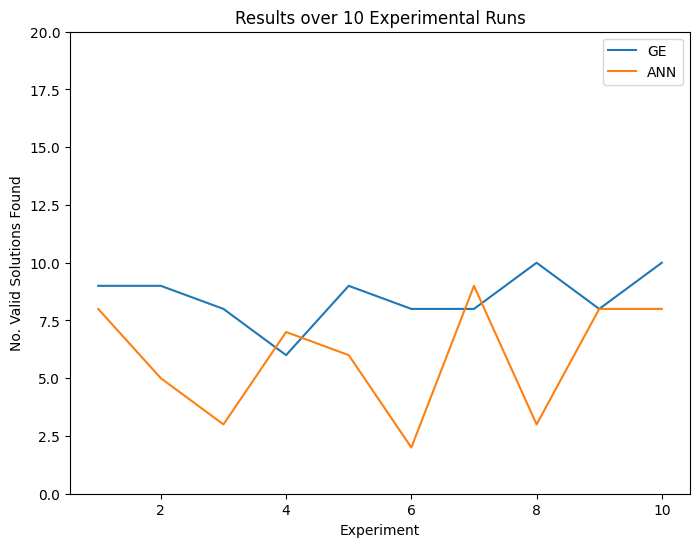

In [5]:
x = [r + 1 for r in range(exp_to_run)]

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(x, ge_results, label='GE')
ax.plot(x, ann_results, label='ANN')
ax.set_title('Results over 10 Experimental Runs')
ax.set_xlabel('Experiment')
ax.set_ylabel('No. Valid Solutions Found')
ax.set_ybound(0, 20)
ax.legend()


In [6]:
ge_results

[9, 9, 8, 6, 9, 8, 8, 10, 8, 10]